## Importing the libraries

In [1]:
import pandas as pd
import io
import requests
import numpy as np
import itertools    
import matplotlib.pyplot as plt
import random

from sklearn.utils import resample
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow import keras

from keras.optimizers import Adam

from imblearn.over_sampling import SMOTE, ADASYN

In [2]:
random.seed(42)

## Auxiliary functions

#### Performance metrics

In [3]:
def performance_metrics(output, prediction):

    p_m = [
        accuracy_score(output, prediction),
        precision_score(output, prediction, average = 'macro'),
        recall_score(output, prediction, average = 'macro'),
        f1_score(output, prediction, average = 'macro')
    ]

    return p_m

#### Confusion matrix

In [4]:
def conf_matrix(output,Prediction, Case):    
    conf = confusion_matrix(output, Prediction)
    plt.figure()
 
    classes = [0, 1, 2]
    # plot confusion matrix
    plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = conf.max() / 2.
    for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
        plt.text(j, i, format(conf[i, j], fmt),
                horizontalalignment="center",
                color="white" if conf[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Plots/Confusion_Matrix/CM_' + Case + ".pdf", format="pdf",bbox_inches="tight")

#### Total performance

In [5]:
def final_performance(model, input, output, Case):
    ## Dataset
    TrainPredictions = model.predict(input)
    TrainPredictions = np.argmax(TrainPredictions, axis=1)

    ## Confusion Matrix
    conf_matrix(output, TrainPredictions, Case)

    ## Performance Metrics
    PM = performance_metrics(output, TrainPredictions)


    ## Classification Reports
    print("\n Classification report for " + Case + '\n')
    print(classification_report(output, TrainPredictions, target_names=['Class 1', 'Class 2', 'Class 3']))

    return PM

#### Neural Network

In [6]:
def fit_model(X_train, y_train, X_test, y_test, Case, 
              class_weights = dict(enumerate([1,1,1])),
              epochs = 5000, batch_size = 200, lr = 0.001, 
              patience = 500, layers = [256,256,256], 
              activ = "tanh"):
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               patience=patience)
    # define model
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(layers[0], 
                                 activation= activ, 
                                 input_shape=(X_train.shape[-1],)))
    
    for i in range(1,len(layers)):
        model.add(keras.layers.Dense(layers[i], activation= activ))
        model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Dense(3, activation = 'sigmoid'))

    #model.summary()

    # Metrics
    metrics = [keras.metrics.FalseNegatives(name="fn"),
               keras.metrics.FalsePositives(name="fp"),
               keras.metrics.TrueNegatives(name="tn"),
               keras.metrics.TruePositives(name="tp"),
               keras.metrics.Precision(name="precision"),
               keras.metrics.Recall(name="recall")
               ]

    # compile model
    opt = Adam(learning_rate = lr)
    
    model.compile(loss="binary_crossentropy", 
                  optimizer=opt, 
                  metrics= metrics)
    
    # fit model
    history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=epochs,  
                        batch_size=batch_size, 
                        verbose=0, 
                        callbacks=[early_stop],
                        class_weight= class_weights
                        )

    # Plotting the results
    plt.figure()
    plt.semilogy(history.history['loss'], label='train')
    plt.semilogy(history.history['val_loss'], label='test')
    plt.legend()
    plt.grid()
    plt.ylabel('Loss function [-]')
    plt.xlabel('Epochs [-]')
    plt.savefig("Plots/History/History_" + Case + ".pdf",format = 'pdf', bbox_inches='tight')

    return model, history

## Pre-processing the data

### Loading the data

Based on the Thyroid Disease database avaliable at https://archive.ics.uci.edu/ml/datasets/Thyroid+Disease

### Training Data

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-train.data"
s = requests.get(url).contents=requests.get(url).content
dataTrain=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

dataTrain.head()

print(dataTrain.shape)
dataTrain.head()

(3772, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0.00060,0.015,0.120,0.082,0.146,3,NaN,NaN
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.030,0.143,0.133,0.108,3,NaN,NaN
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0.00190,0.024,0.102,0.131,0.078,3,NaN,NaN
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0.00090,0.017,0.077,0.090,0.085,3,NaN,NaN
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0.00025,0.026,0.139,0.090,0.153,3,NaN,NaN


##### Removing missing Data

In [8]:
del dataTrain[22]
del dataTrain[23]
dataTrain.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.73,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0.00060,0.015,0.120,0.082,0.146,3
1,0.24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.030,0.143,0.133,0.108,3
2,0.47,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00190,0.024,0.102,0.131,0.078,3
3,0.64,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00090,0.017,0.077,0.090,0.085,3
4,0.23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.00025,0.026,0.139,0.090,0.153,3


##### Separating the Data

In [9]:
#Predictor data
inputTrain = dataTrain.drop([21], axis=1)

#Target data
outputTrain = dataTrain[21] - 1     

### Test Data

In [10]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/ann-test.data"
s = requests.get(url).contents=requests.get(url).content
dataTest=pd.read_csv(io.StringIO(s.decode('utf-8')),delimiter=' ',header=None)

dataTest.head()

print(dataTest.shape)
dataTest.head()

(3428, 24)


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.29,0,0,0,0,0,0,0,0,0,...,0,0,0.0061,0.028,0.111,0.131,0.085,2,NaN,NaN
1,0.32,0,0,0,0,0,0,0,0,0,...,0,0,0.0013,0.019,0.084,0.078,0.107,3,NaN,NaN
2,0.35,0,0,0,0,0,0,0,0,0,...,0,0,0.0000,0.031,0.239,0.100,0.239,3,NaN,NaN
3,0.21,0,0,0,0,0,0,0,0,0,...,0,0,0.0010,0.018,0.087,0.088,0.099,3,NaN,NaN
4,0.22,0,0,0,0,1,0,0,0,0,...,0,0,0.0004,0.022,0.134,0.135,0.099,3,NaN,NaN


##### Revoving missing Data

In [11]:
del dataTest[22]
del dataTest[23]
dataTest.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.29,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0061,0.028,0.111,0.131,0.085,2
1,0.32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0013,0.019,0.084,0.078,0.107,3
2,0.35,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0000,0.031,0.239,0.100,0.239,3
3,0.21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0.0010,0.018,0.087,0.088,0.099,3
4,0.22,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0.0004,0.022,0.134,0.135,0.099,3


##### Separating the Data

In [12]:
# Predictor data
inputTest = dataTest.drop([21], axis=1)

# Target data 
outputTest = dataTest[21] - 1

### Data normalization

In [13]:
# MinMax Scaller
scaler = preprocessing.MinMaxScaler()

# fit using the train set
scaler.fit(inputTrain)

# transform the test test
xtrainN = scaler.transform(inputTrain)
xtestN = scaler.transform(inputTest) 

### Encoding the target data

In [14]:
outputTrain_one_hot = keras.utils.to_categorical(outputTrain)

### Class imbalance

In [15]:
print("Proportion of classes in the dataset")
counts = np.bincount(outputTrain)

print(counts)
print("Training set:",  counts/ float(len(outputTrain)))
print("Test set:", np.bincount(outputTest) / float(len(outputTest)))

weights_class1 = 1.0/counts[0]
weights_class2 = 1.0/counts[1]
weights_class3 = 1.0/counts[2]

class_weights = compute_class_weight('balanced', 
                                     classes = np.unique(outputTrain), 
                                     y = outputTrain)
print(class_weights)

d_class_weights = dict(enumerate(class_weights))

Proportion of classes in the dataset
[  93  191 3488]
Training set: [0.02465536 0.05063627 0.92470838]
Test set: [0.02129522 0.05163361 0.92707118]
[13.51971326  6.58289703  0.36047401]


### Train - Validation Split

In [16]:
X_train, X_validation, y_train, y_validation = model_selection.train_test_split(
                                                                                xtrainN, 
                                                                                outputTrain_one_hot, 
                                                                                test_size = 0.3, 
                                                                                random_state = 1, 
                                                                                stratify=outputTrain
                                                                                )  

## Imbalance Techniques Evaluation

### Case 1 - Base

118/118 [==============================] - 0s 2ms/step

 Classification report for Case_Base_train

              precision    recall  f1-score   support

     Class 1       0.70      0.94      0.80        93
     Class 2       0.93      0.28      0.43       191
     Class 3       0.97      1.00      0.98      3488

    accuracy                           0.96      3772
   macro avg       0.87      0.74      0.74      3772
weighted avg       0.96      0.96      0.95      3772

108/108 [==============================] - 0s 1ms/step

 Classification report for Case_Base_test

              precision    recall  f1-score   support

     Class 1       0.68      0.86      0.76        73
     Class 2       0.82      0.34      0.48       177
     Class 3       0.97      0.99      0.98      3178

    accuracy                           0.95      3428
   macro avg       0.82      0.73      0.74      3428
weighted avg       0.95      0.95      0.95      3428



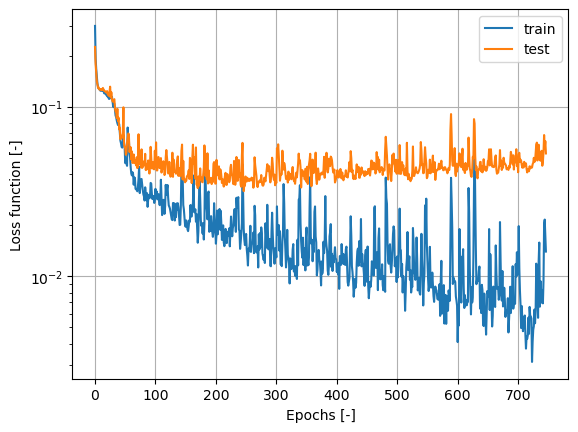

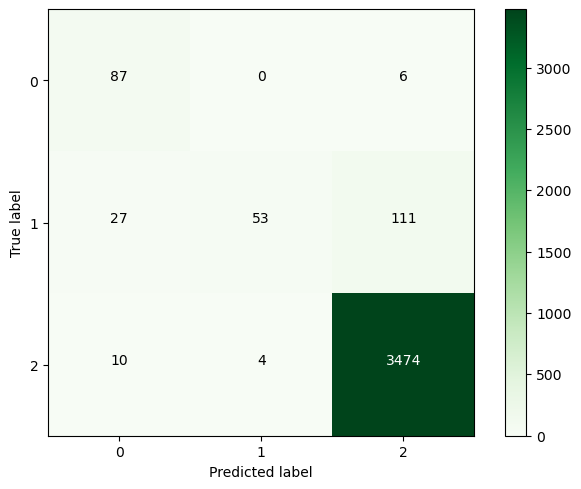

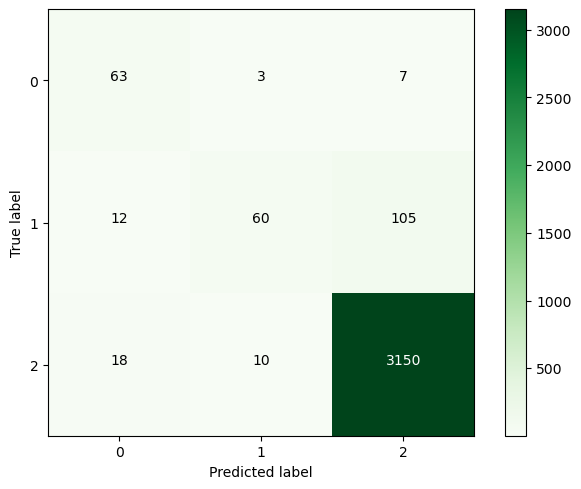

In [17]:
## Performance metrics array

PM_train = []
PM_test = []

Data = {
    'epochs' : 5000, 
    'batch_size': 200,
    'lr' : 0.001,
    'patience': 500,
    'layers': [256,256,256],
    'activ': "tanh"
    }


Case = "Case_Base"

#Training
model,history = fit_model(X_train, y_train, X_validation, y_validation, Case, **Data)

# Results for the training set
PM_train.append(final_performance(model, inputTrain, outputTrain, Case + '_train'))

# Results for the test set
PM_test.append(final_performance(model, inputTest, outputTest, Case + '_test'))

### Case 2 - Weighted Classes

118/118 [==============================] - 0s 1ms/step

 Classification report for Case_Weights_train

              precision    recall  f1-score   support

     Class 1       0.68      0.94      0.79        93
     Class 2       0.93      0.41      0.57       191
     Class 3       0.98      1.00      0.99      3488

    accuracy                           0.96      3772
   macro avg       0.86      0.78      0.78      3772
weighted avg       0.97      0.96      0.96      3772

108/108 [==============================] - 0s 1ms/step

 Classification report for Case_Weights_test

              precision    recall  f1-score   support

     Class 1       0.70      0.89      0.78        73
     Class 2       0.82      0.42      0.56       177
     Class 3       0.97      0.99      0.98      3178

    accuracy                           0.96      3428
   macro avg       0.83      0.77      0.77      3428
weighted avg       0.96      0.96      0.96      3428



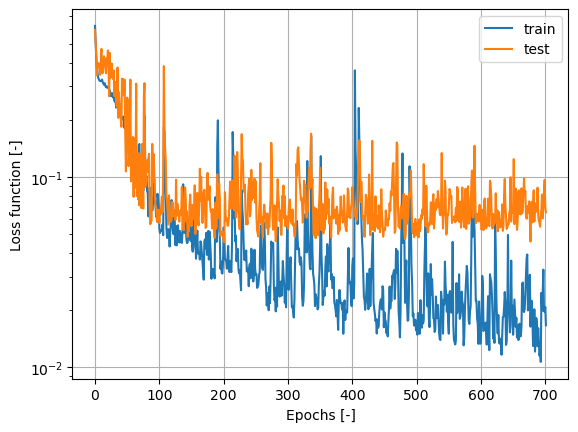

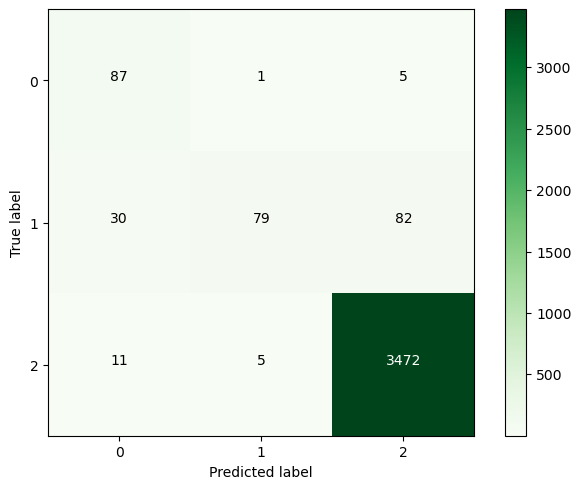

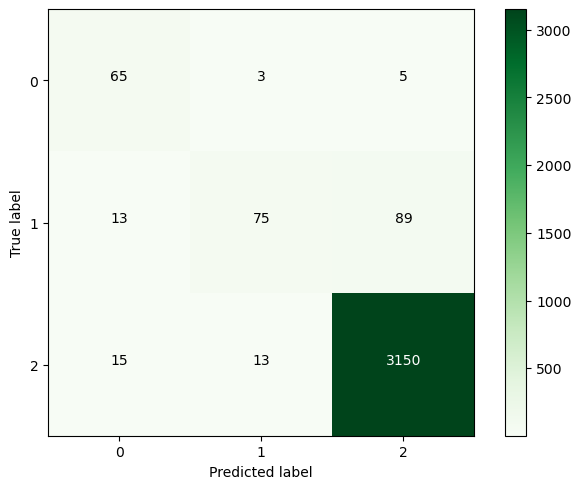

In [18]:
Case = "Case_Weights"

#Training
model_weights ,history_weights = fit_model(X_train, y_train, X_validation, y_validation, Case, class_weights = d_class_weights, **Data)

# Results for the training set
PM_train.append(final_performance(model_weights, inputTrain, outputTrain, Case + '_train'))

# Results for the test set
PM_test.append(final_performance(model_weights, inputTest, outputTest, Case + '_test'))

### Case 3 - Oversampling 

#### Separating the Data

In [19]:
Input_2 = dataTrain[dataTrain[21]-1 == 2]
Input_1 = dataTrain[dataTrain[21]-1 == 1]
Input_0 = dataTrain[dataTrain[21]-1 == 0]

#### Oversampling of the classes

In [20]:
# Oversampling of class 1
Input_1_over = resample(Input_1, 
                        replace=True,    
                        n_samples= len(Input_2), 
                        random_state=42) 
 
# Oversampling of class 0
Input_0_over = resample(Input_0, 
                        replace=True,    
                        n_samples= len(Input_2), 
                        random_state=42) 
# Creation of the new data frame
dataTrain_over = pd.concat([Input_0_over ,Input_1_over, Input_2]) 

#### Separating the Data

In [21]:
#Predictor data
inputTrain_over = dataTrain_over.drop([21], axis=1)

#Target data
outputTrain_over = dataTrain_over[21] - 1    

In [22]:
print("Proportion of classes in the dataset")
counts = np.bincount(outputTrain_over)

print(counts)
print("Training set:",  counts/ float(len(outputTrain_over)))


Proportion of classes in the dataset
[3488 3488 3488]
Training set: [0.33333333 0.33333333 0.33333333]


#### Data Normalization

In [23]:
# MinMax Scaller
scaler_over = preprocessing.MinMaxScaler()

# fit using the train set
scaler.fit(inputTrain_over)

# transform the test test
xtrainN_over = scaler.transform(inputTrain_over)
xtestN = scaler.transform(inputTest)

#### Encoding the target data

In [24]:
outputTrain_one_hot_over = keras.utils.to_categorical(outputTrain_over)

#### Training Validation Split

In [25]:
X_train_over, X_validation_over, y_train_over, y_validation_over = model_selection.train_test_split(
                                                                                                    xtrainN_over, 
                                                                                                    outputTrain_one_hot_over, 
                                                                                                    test_size = 0.3, 
                                                                                                    random_state = 1, 
                                                                                                    stratify=outputTrain_over
                                                                                                    )  


#### Trainning and results

327/327 [==============================] - 0s 968us/step

 Classification report for Case_Over_train

              precision    recall  f1-score   support

     Class 1       0.83      0.95      0.89      3488
     Class 2       0.99      0.27      0.43      3488
     Class 3       0.63      1.00      0.77      3488

    accuracy                           0.74     10464
   macro avg       0.82      0.74      0.69     10464
weighted avg       0.82      0.74      0.69     10464

108/108 [==============================] - 0s 1ms/step

 Classification report for Case_Over_test

              precision    recall  f1-score   support

     Class 1       0.65      0.92      0.76        73
     Class 2       0.84      0.39      0.53       177
     Class 3       0.97      0.99      0.98      3178

    accuracy                           0.96      3428
   macro avg       0.82      0.77      0.76      3428
weighted avg       0.96      0.96      0.95      3428



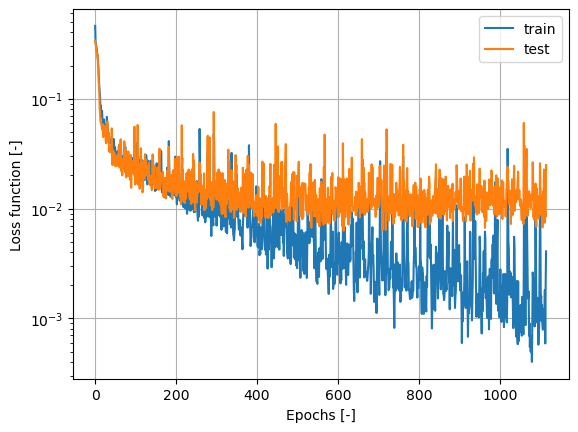

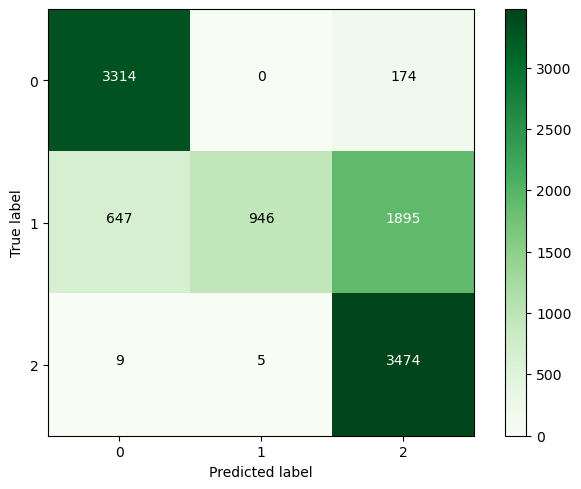

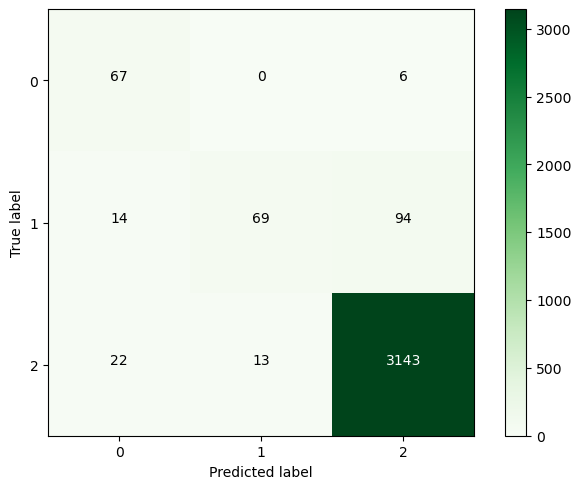

In [26]:
Case = "Case_Over"

#Training
model_over,history_over = fit_model(X_train_over, y_train_over, X_validation_over, y_validation_over, Case, **Data)

# Results for the training set
PM_train.append(final_performance(model_over, inputTrain_over, outputTrain_over, Case + '_train'))

# Results for the test set
PM_test.append(final_performance(model_over, inputTest, outputTest, Case + '_test'))

### Case 4 - Undersampling

In [27]:
# Undersampling of class 1
Input_1_under = resample(Input_1, 
                        replace=True,    
                        n_samples= len(Input_0), 
                        random_state=42) 
 
# undersampling of class 0
Input_2_under = resample(Input_2, 
                        replace=True,    
                        n_samples= len(Input_0), 
                        random_state=42) 
# Creation of the new data frame
dataTrain_under = pd.concat([Input_2_under ,Input_1_under, Input_0]) 

#### Separating the Data

In [28]:
#Predictor data
inputTrain_under = dataTrain_under.drop([21], axis=1)

#Target data
outputTrain_under = dataTrain_under[21] - 1    

In [29]:
print("Proportion of classes in the dataset")
counts = np.bincount(outputTrain_under)

print(counts)
print("Training set:",  counts/ float(len(outputTrain_under)))


Proportion of classes in the dataset
[93 93 93]
Training set: [0.33333333 0.33333333 0.33333333]


#### Data Normalization

In [30]:
# MinMax Scaller
scaler_under = preprocessing.MinMaxScaler()

# fit using the train set
scaler.fit(inputTrain_under)

# transform the test test
xtrainN_under = scaler.transform(inputTrain_under)
xtestN = scaler.transform(inputTest)

#### Encoding the target data

In [31]:
outputTrain_one_hot_under = keras.utils.to_categorical(outputTrain_under)

#### Training Validation Split

In [32]:
X_train_under, X_validation_under, y_train_under, y_validation_under = model_selection.train_test_split(
                                                                                                    xtrainN_under, 
                                                                                                    outputTrain_one_hot_under, 
                                                                                                    test_size = 0.3, 
                                                                                                    random_state = 1, 
                                                                                                    stratify=outputTrain_under
                                                                                                    )  


#### Training and Results

9/9 [==============================] - 0s 1ms/step


c:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Guilherme\Anaconda3\lib\site-packages\sklearn\m


 Classification report for Case_Under_train

              precision    recall  f1-score   support

     Class 1       0.47      1.00      0.64        93
     Class 2       0.00      0.00      0.00        93
     Class 3       0.95      0.85      0.90        93

    accuracy                           0.62       279
   macro avg       0.48      0.62      0.51       279
weighted avg       0.48      0.62      0.51       279

108/108 [==============================] - 0s 1ms/step

 Classification report for Case_Under_test

              precision    recall  f1-score   support

     Class 1       0.07      0.99      0.13        73
     Class 2       0.00      0.00      0.00       177
     Class 3       0.99      0.74      0.85      3178

    accuracy                           0.71      3428
   macro avg       0.35      0.58      0.33      3428
weighted avg       0.92      0.71      0.79      3428



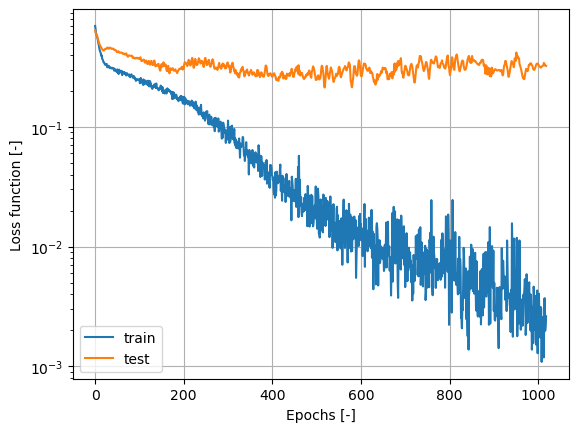

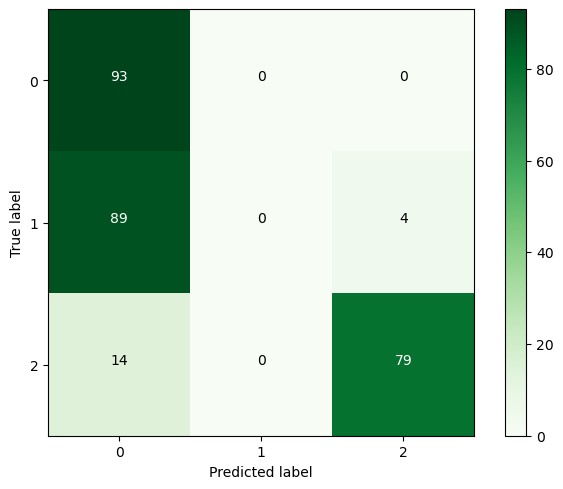

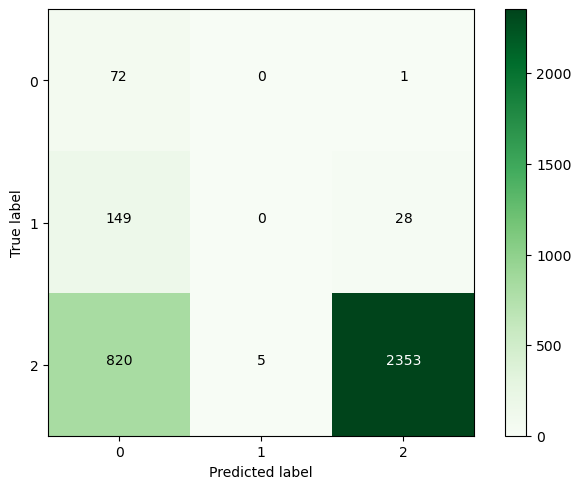

In [33]:
Case = "Case_Under"

#Training
model_under,history_under = fit_model(X_train_under, y_train_under, X_validation_under, y_validation_under, Case, **Data)

# Results for the training set
PM_train.append(final_performance(model_under, inputTrain_under, outputTrain_under, Case + '_train'))

# Results for the test set
PM_test.append(final_performance(model_under, inputTest, outputTest, Case + '_test'))

### Case 5 - SMOTE

In [34]:
# Resampling the minority class
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Transforming the Dataset
inputTrain_smt_prev, outputTrain_smt_prev = sm.fit_resample(inputTrain, outputTrain)

# Transforming the Dataset
inputTrain_smote, outputTrain_smote = sm.fit_resample(inputTrain_smt_prev, outputTrain_smt_prev)

In [35]:
print("Proportion of classes in the dataset")
counts = np.bincount(outputTrain_smote)

print(counts)
print("Training set:",  counts/ float(len(outputTrain_smote)))

Proportion of classes in the dataset
[3488 3488 3488]
Training set: [0.33333333 0.33333333 0.33333333]


#### Data Normalization

In [36]:
# MinMax Scaller
scaler_smote = preprocessing.MinMaxScaler()

# fit using the train set
scaler.fit(inputTrain_smote)

# transform the test test
xtrainN_smote = scaler.transform(inputTrain_smote)
xtestN = scaler.transform(inputTest)

#### Encoding the target data

In [37]:
outputTrain_one_hot_smote = keras.utils.to_categorical(outputTrain_smote)

#### Training Validation Split

In [38]:
X_train_smote, X_validation_smote, y_train_smote, y_validation_smote = model_selection.train_test_split(
                                                                                                    xtrainN_smote, 
                                                                                                    outputTrain_one_hot_smote, 
                                                                                                    test_size = 0.3, 
                                                                                                    random_state = 1, 
                                                                                                    stratify=outputTrain_smote
                                                                                                    )  


#### Training and Results

327/327 [==============================] - 0s 919us/step

 Classification report for Case_Smote_train

              precision    recall  f1-score   support

     Class 1       0.82      0.98      0.89      3488
     Class 2       0.99      0.20      0.33      3488
     Class 3       0.62      1.00      0.77      3488

    accuracy                           0.72     10464
   macro avg       0.81      0.72      0.66     10464
weighted avg       0.81      0.72      0.66     10464

108/108 [==============================] - 0s 955us/step

 Classification report for Case_Smote_test

              precision    recall  f1-score   support

     Class 1       0.64      0.89      0.75        73
     Class 2       0.84      0.27      0.40       177
     Class 3       0.96      0.99      0.98      3178

    accuracy                           0.95      3428
   macro avg       0.82      0.72      0.71      3428
weighted avg       0.95      0.95      0.94      3428



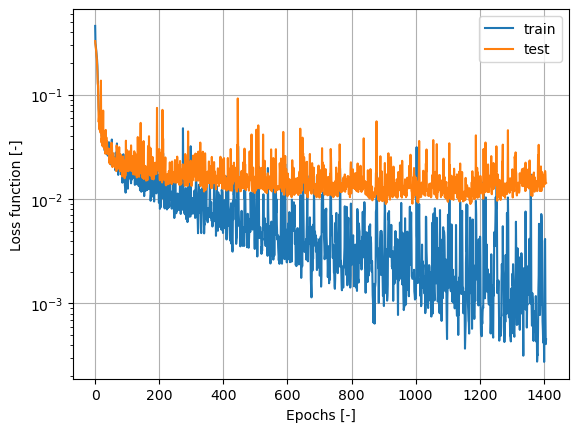

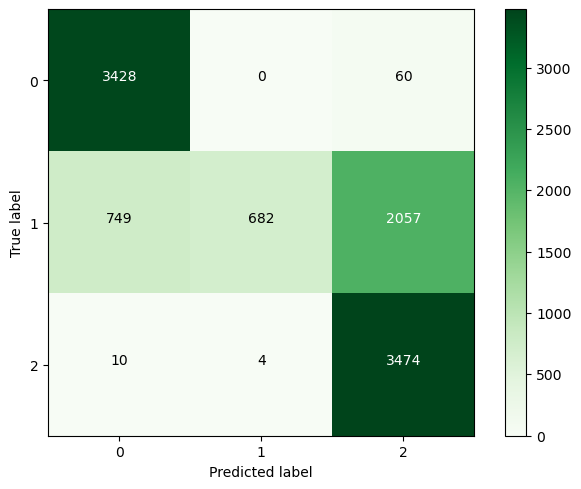

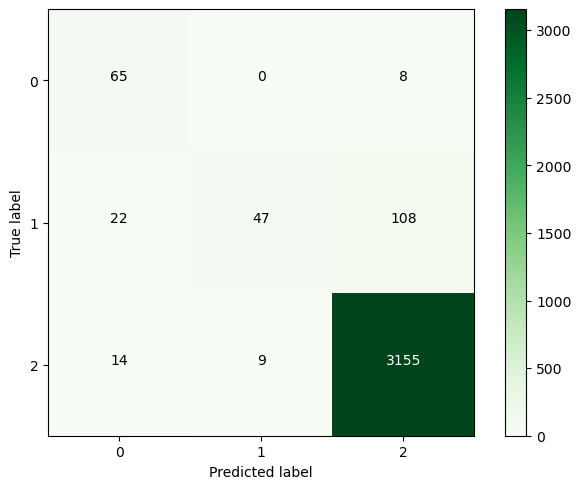

In [39]:
Case = "Case_Smote"

#Training
model_smote,history_smote = fit_model(X_train_smote, y_train_smote, X_validation_smote, y_validation_smote, Case, **Data)

# Results for the training set
PM_train.append(final_performance(model_smote, inputTrain_smote, outputTrain_smote, Case + '_train'))

# Results for the test set
PM_test.append(final_performance(model_smote, inputTest, outputTest, Case + '_test'))

### Case 6 - ADASYN

In [40]:
# Resampling the minority class
ad = ADASYN(sampling_strategy='minority', random_state=42)

# Transforming the Dataset
inputTrain_ads_prev, outputTrain_ads_prev = sm.fit_resample(inputTrain, outputTrain)

# Transforming the Dataset
inputTrain_adasyn, outputTrain_adasyn = sm.fit_resample(inputTrain_ads_prev, outputTrain_ads_prev)

In [41]:
print("Proportion of classes in the dataset")
counts = np.bincount(outputTrain_adasyn)

print(counts)
print("Training set:",  counts/ float(len(outputTrain_adasyn)))

Proportion of classes in the dataset
[3488 3488 3488]
Training set: [0.33333333 0.33333333 0.33333333]


#### Data Normalization

In [42]:
# MinMax Scaller
scaler_adasyn = preprocessing.MinMaxScaler()

# fit using the train set
scaler.fit(inputTrain_adasyn)

# transform the test test
xtrainN_adasyn = scaler.transform(inputTrain_adasyn)
xtestN = scaler.transform(inputTest)

#### Encoding the target data

In [43]:
outputTrain_one_hot_adasyn = keras.utils.to_categorical(outputTrain_adasyn)

#### Training Validation split

In [44]:
X_train_adasyn, X_validation_adasyn, y_train_adasyn, y_validation_adasyn = model_selection.train_test_split(
                                                                                                    xtrainN_adasyn, 
                                                                                                    outputTrain_one_hot_adasyn, 
                                                                                                    test_size = 0.3, 
                                                                                                    random_state = 1, 
                                                                                                    stratify=outputTrain_adasyn
                                                                                                    )  


#### Training and Results

327/327 [==============================] - 0s 1ms/step

 Classification report for Case_ADASYN_train

              precision    recall  f1-score   support

     Class 1       0.84      0.99      0.91      3488
     Class 2       1.00      0.33      0.49      3488
     Class 3       0.67      1.00      0.80      3488

    accuracy                           0.77     10464
   macro avg       0.84      0.77      0.73     10464
weighted avg       0.84      0.77      0.73     10464

108/108 [==============================] - 0s 1ms/step

 Classification report for Case_ADASYN_test

              precision    recall  f1-score   support

     Class 1       0.70      0.88      0.78        73
     Class 2       0.84      0.38      0.53       177
     Class 3       0.97      0.99      0.98      3178

    accuracy                           0.96      3428
   macro avg       0.84      0.75      0.76      3428
weighted avg       0.96      0.96      0.95      3428



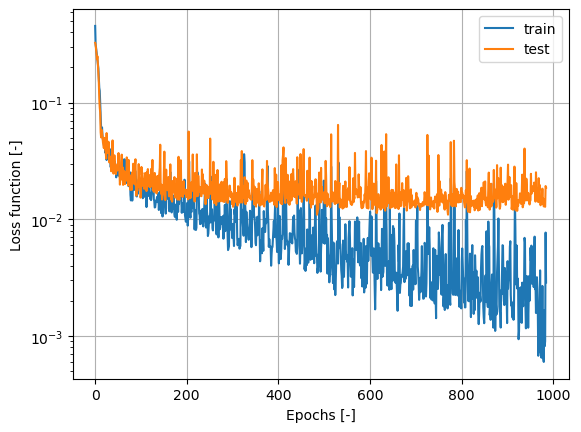

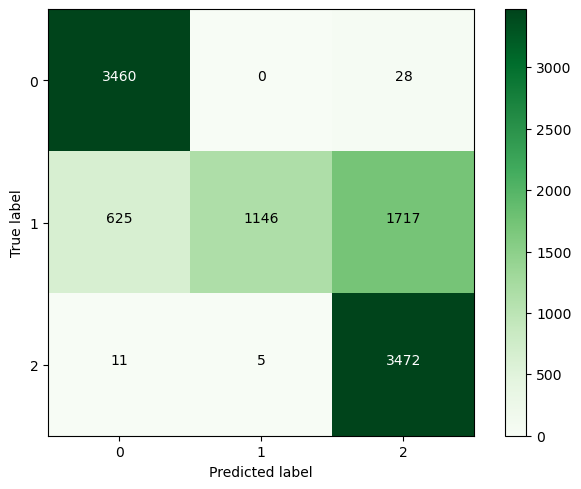

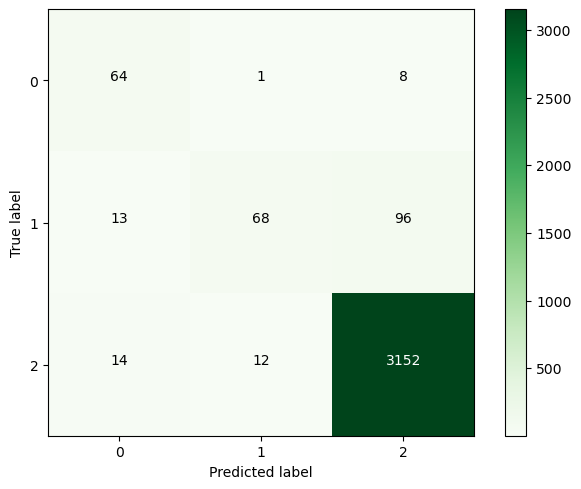

In [45]:
Case = "Case_ADASYN"

#Training
model_adasyn,history_adasyn = fit_model(X_train_adasyn, y_train_adasyn, X_validation_adasyn, y_validation_adasyn, Case, **Data)

# Results for the training set
PM_train.append(final_performance(model_adasyn, inputTrain_adasyn, outputTrain_adasyn, Case + '_train'))

# Results for the test set
PM_test.append(final_performance(model_adasyn, inputTest, outputTest, Case + '_test'))

### Evaluation of the resusults

In [46]:
#### Training set
pd.DataFrame(PM_train, columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']).to_excel("Metrics/Unbalancing_Metrics_train.xlsx")
pd.DataFrame(PM_train, columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])

,Accuracy,Precision,Recall,F1 Score
0,0.958112,0.866285,0.736319,0.736919
1,0.964475,0.861551,0.781503,0.781726
2,0.739106,0.818747,0.739106,0.694761
3,0.616487,0.475432,0.616487,0.513775
4,0.724771,0.811416,0.724771,0.661786
5,0.771980,0.835300,0.771980,0.734741


In [47]:
#### Test set
pd.DataFrame(PM_test, columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']).to_excel("Metrics/Unbalancing_Metrics_test.xlsx")
pd.DataFrame(PM_test, columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])

,Accuracy,Precision,Recall,F1 Score
0,0.954784,0.821667,0.731062,0.739099
1,0.959743,0.831375,0.768443,0.774612
2,0.956534,0.820371,0.765542,0.757719
3,0.707410,0.352330,0.575568,0.325222
4,0.953034,0.815796,0.716237,0.709669
5,0.957993,0.836954,0.750904,0.762471


## Hyperparameter Evaluations

In [48]:
## Empty lists
HY_Data = []
HY_metrics_train = []
HY_metrics_test = []

#### Base

118/118 [==============================] - 0s 1ms/step

 Classification report for Case_Hyp_Base_train

              precision    recall  f1-score   support

     Class 1       0.65      0.96      0.78        93
     Class 2       0.94      0.42      0.58       191
     Class 3       0.98      1.00      0.99      3488

    accuracy                           0.97      3772
   macro avg       0.86      0.79      0.78      3772
weighted avg       0.97      0.97      0.96      3772

108/108 [==============================] - 0s 996us/step

 Classification report for Case_Hyp_Base_test

              precision    recall  f1-score   support

     Class 1       0.69      0.90      0.79        73
     Class 2       0.84      0.49      0.62       177
     Class 3       0.97      0.99      0.98      3178

    accuracy                           0.96      3428
   macro avg       0.84      0.79      0.80      3428
weighted avg       0.96      0.96      0.96      3428



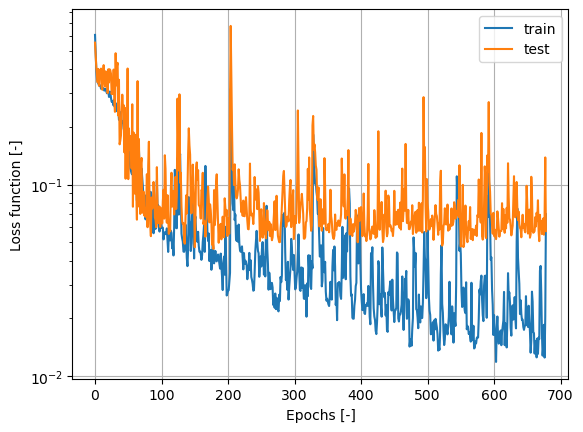

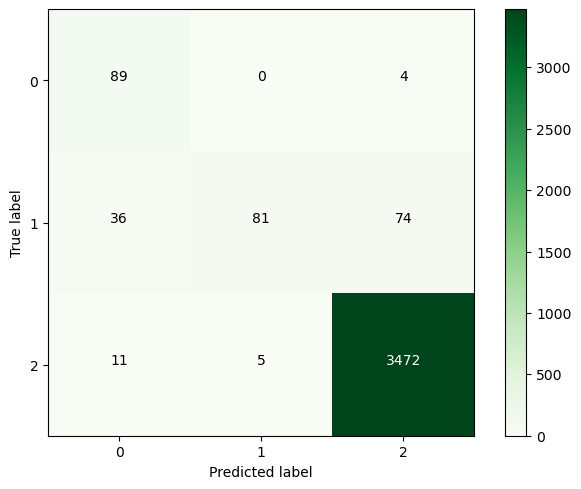

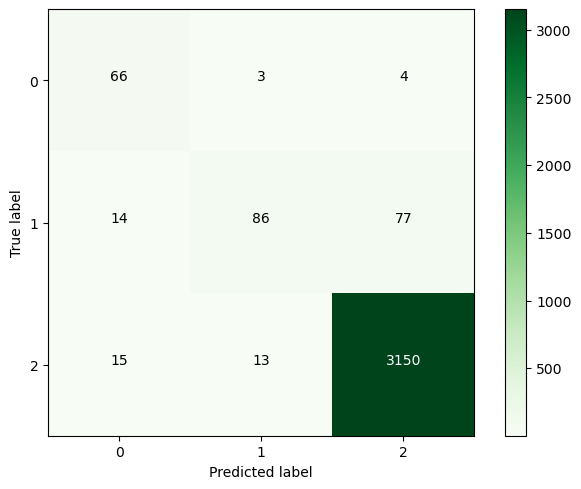

In [49]:
Data = {
    'epochs' : 5000, 
    'batch_size': 200,
    'lr' : 0.001,
    'patience': 500,
    'layers': [256,256,256],
    'activ': "tanh"
    }

HY_Data.append(Data)

Case = "Case_Hyp_Base"

#Training
model_weights ,history_weights = fit_model(X_train, y_train, X_validation, y_validation, Case, class_weights = d_class_weights, **Data)

# Results for the training set
HY_metrics_train.append(final_performance(model_weights, inputTrain, outputTrain, Case + '_train'))

# Results for the test set
HY_metrics_test.append(final_performance(model_weights, inputTest, outputTest, Case + '_test'))

#### Learning rate

118/118 [==============================] - 0s 962us/step

 Classification report for Case_Hyp_Learning_Rate_1_train

              precision    recall  f1-score   support

     Class 1       0.47      0.98      0.64        93
     Class 2       0.93      0.52      0.67       191
     Class 3       0.99      0.98      0.98      3488

    accuracy                           0.96      3772
   macro avg       0.80      0.83      0.76      3772
weighted avg       0.97      0.96      0.96      3772

108/108 [==============================] - 0s 975us/step

 Classification report for Case_Hyp_Learning_Rate_1_test

              precision    recall  f1-score   support

     Class 1       0.40      0.92      0.56        73
     Class 2       0.83      0.58      0.68       177
     Class 3       0.98      0.97      0.98      3178

    accuracy                           0.95      3428
   macro avg       0.74      0.82      0.74      3428
weighted avg       0.96      0.95      0.95      3428



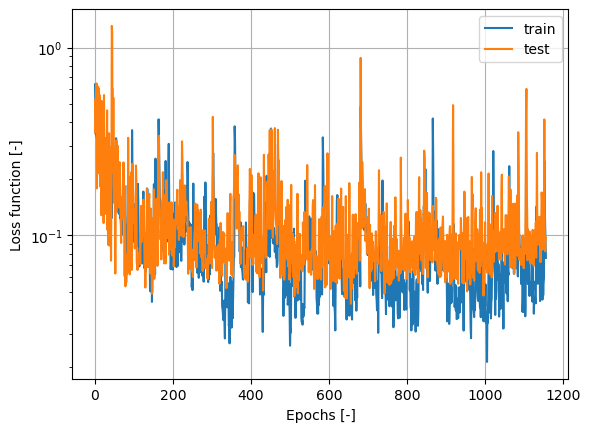

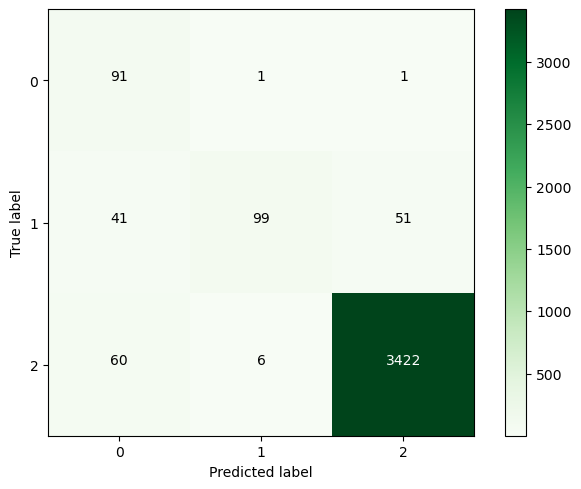

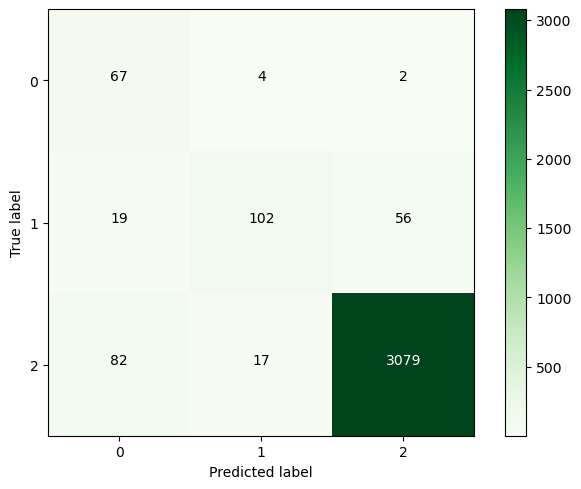

In [50]:
Data = {
    'epochs' : 5000, 
    'batch_size': 200,
    'lr' : 0.01,
    'patience': 500,
    'layers': [256,256,256],
    'activ': "tanh"
    }

HY_Data.append(Data)

Case = "Case_Hyp_Learning_Rate_1"

#Training
model_weights ,history_weights = fit_model(X_train, y_train, X_validation, y_validation, Case, class_weights = d_class_weights, **Data)

# Results for the training set
HY_metrics_train.append(final_performance(model_weights, inputTrain, outputTrain, Case + '_train'))

# Results for the test set
HY_metrics_test.append(final_performance(model_weights, inputTest, outputTest, Case + '_test'))

118/118 [==============================] - 0s 2ms/step

 Classification report for Case_Hyp_Learning_Rate_2_train

              precision    recall  f1-score   support

     Class 1       0.70      0.96      0.81        93
     Class 2       0.94      0.41      0.57       191
     Class 3       0.98      1.00      0.99      3488

    accuracy                           0.97      3772
   macro avg       0.87      0.79      0.79      3772
weighted avg       0.97      0.97      0.96      3772

108/108 [==============================] - 0s 2ms/step

 Classification report for Case_Hyp_Learning_Rate_2_test

              precision    recall  f1-score   support

     Class 1       0.71      0.90      0.80        73
     Class 2       0.83      0.45      0.58       177
     Class 3       0.97      0.99      0.98      3178

    accuracy                           0.96      3428
   macro avg       0.84      0.78      0.79      3428
weighted avg       0.96      0.96      0.96      3428



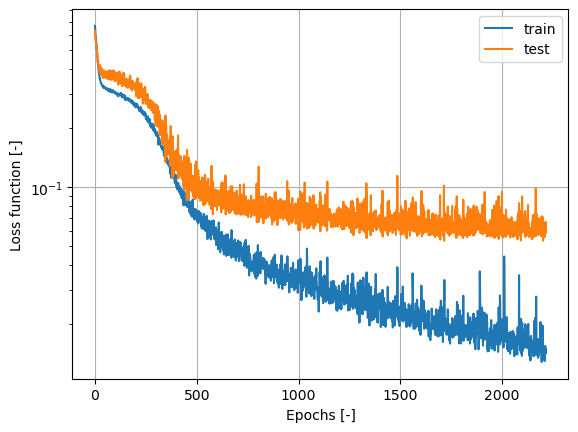

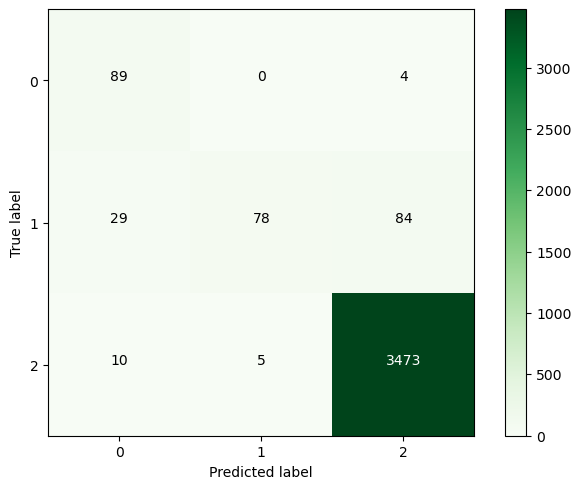

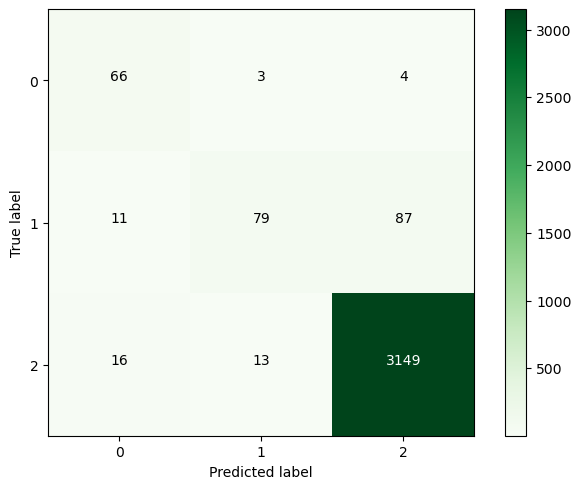

In [51]:
Data = {
    'epochs' : 5000, 
    'batch_size': 200,
    'lr' : 0.0001,
    'patience': 500,
    'layers': [256,256,256],
    'activ': "tanh"
    }

HY_Data.append(Data)

Case = "Case_Hyp_Learning_Rate_2"

#Training
model_weights ,history_weights = fit_model(X_train, y_train, X_validation, y_validation, Case, class_weights = d_class_weights, **Data)

# Results for the training set
HY_metrics_train.append(final_performance(model_weights, inputTrain, outputTrain, Case + '_train'))

# Results for the test set
HY_metrics_test.append(final_performance(model_weights, inputTest, outputTest, Case + '_test'))

#### Batch Size

118/118 [==============================] - 0s 1ms/step

 Classification report for Case_Hyp_Batch_Size_1_train

              precision    recall  f1-score   support

     Class 1       0.69      0.91      0.78        93
     Class 2       0.92      0.43      0.59       191
     Class 3       0.98      1.00      0.99      3488

    accuracy                           0.97      3772
   macro avg       0.86      0.78      0.79      3772
weighted avg       0.97      0.97      0.96      3772

108/108 [==============================] - 0s 1ms/step

 Classification report for Case_Hyp_Batch_Size_1_test

              precision    recall  f1-score   support

     Class 1       0.68      0.85      0.76        73
     Class 2       0.82      0.44      0.57       177
     Class 3       0.97      0.99      0.98      3178

    accuracy                           0.96      3428
   macro avg       0.82      0.76      0.77      3428
weighted avg       0.96      0.96      0.96      3428



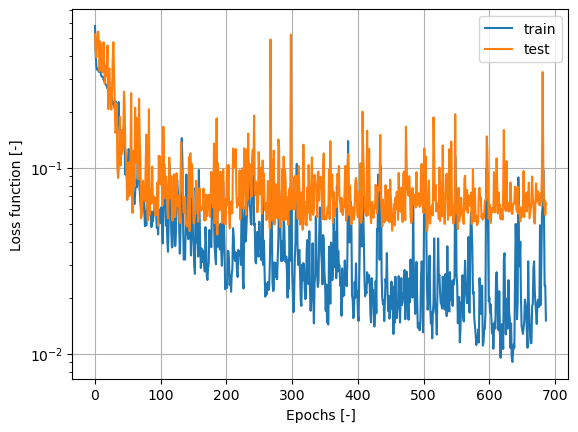

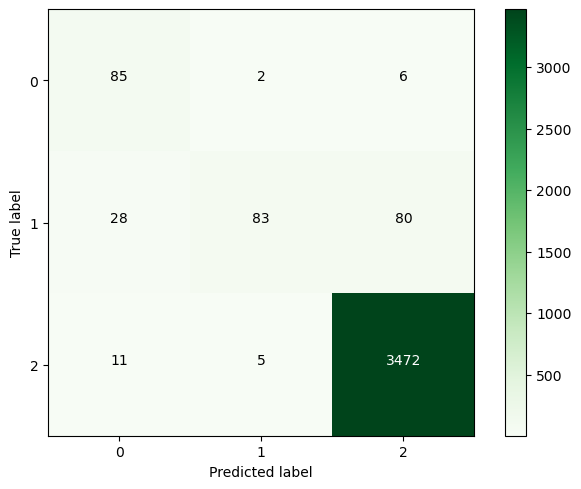

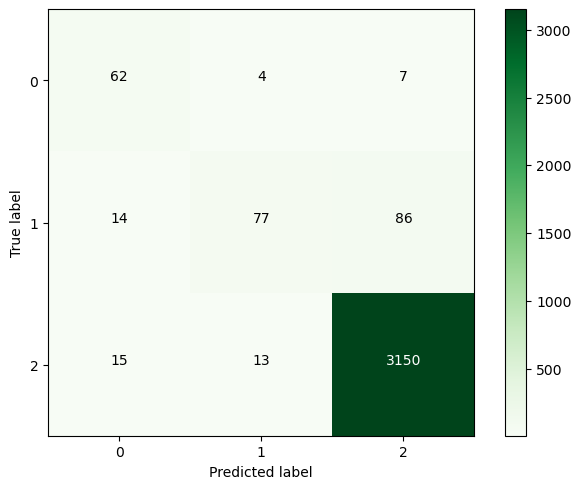

In [52]:
Data = {
    'epochs' : 5000, 
    'batch_size': 100,
    'lr' : 0.001,
    'patience': 500,
    'layers': [256,256,256],
    'activ': "tanh"
    }

HY_Data.append(Data)

Case = "Case_Hyp_Batch_Size_1"

#Training
model_weights ,history_weights = fit_model(X_train, y_train, X_validation, y_validation, Case, class_weights = d_class_weights, **Data)

# Results for the training set
HY_metrics_train.append(final_performance(model_weights, inputTrain, outputTrain, Case + '_train'))

# Results for the test set
HY_metrics_test.append(final_performance(model_weights, inputTest, outputTest, Case + '_test'))

118/118 [==============================] - 0s 1ms/step

 Classification report for Case_Hyp_Batch_Size_2_train

              precision    recall  f1-score   support

     Class 1       0.61      0.95      0.74        93
     Class 2       0.94      0.40      0.56       191
     Class 3       0.98      0.99      0.99      3488

    accuracy                           0.96      3772
   macro avg       0.84      0.78      0.76      3772
weighted avg       0.97      0.96      0.96      3772

108/108 [==============================] - 0s 1ms/step

 Classification report for Case_Hyp_Batch_Size_2_test

              precision    recall  f1-score   support

     Class 1       0.65      0.88      0.74        73
     Class 2       0.82      0.42      0.56       177
     Class 3       0.97      0.99      0.98      3178

    accuracy                           0.96      3428
   macro avg       0.81      0.76      0.76      3428
weighted avg       0.96      0.96      0.95      3428



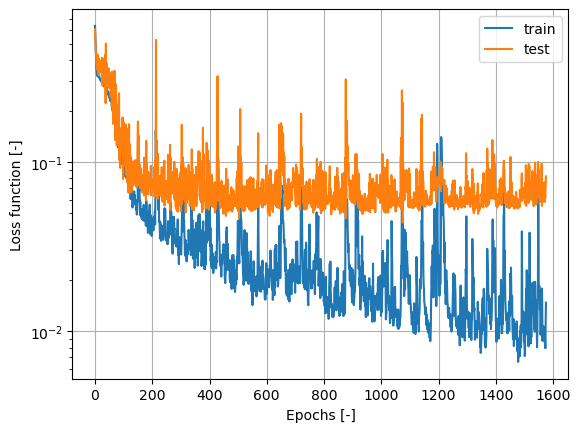

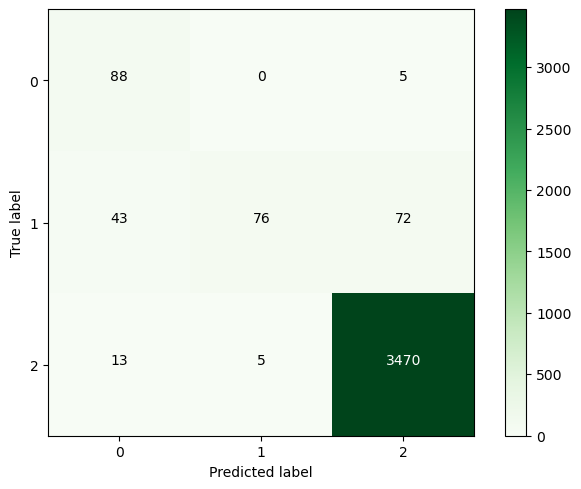

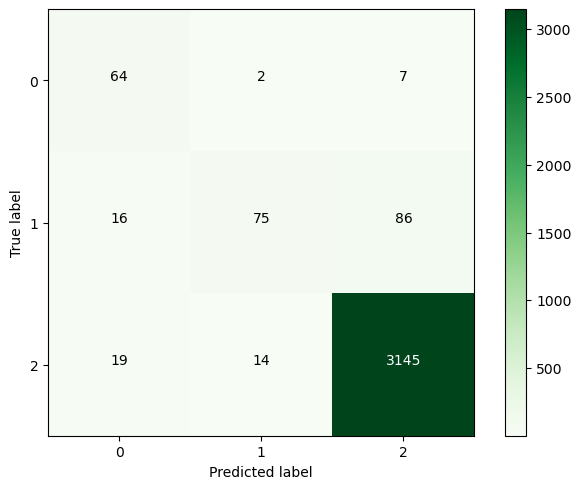

In [53]:
Data = {
    'epochs' : 5000, 
    'batch_size': 500,
    'lr' : 0.001,
    'patience': 500,
    'layers': [256,256,256],
    'activ': "tanh"
    }

HY_Data.append(Data)

Case = "Case_Hyp_Batch_Size_2"

#Training
model_weights ,history_weights = fit_model(X_train, y_train, X_validation, y_validation, Case, class_weights = d_class_weights, **Data)

# Results for the training set
HY_metrics_train.append(final_performance(model_weights, inputTrain, outputTrain, Case + '_train'))

# Results for the test set
HY_metrics_test.append(final_performance(model_weights, inputTest, outputTest, Case + '_test'))

#### Patience

118/118 [==============================] - 0s 1ms/step

 Classification report for Case_Hyp_Patience_1_train

              precision    recall  f1-score   support

     Class 1       0.68      0.96      0.79        93
     Class 2       0.92      0.42      0.58       191
     Class 3       0.98      0.99      0.99      3488

    accuracy                           0.96      3772
   macro avg       0.86      0.79      0.79      3772
weighted avg       0.97      0.96      0.96      3772

108/108 [==============================] - 0s 1ms/step

 Classification report for Case_Hyp_Patience_1_test

              precision    recall  f1-score   support

     Class 1       0.71      0.89      0.79        73
     Class 2       0.82      0.45      0.58       177
     Class 3       0.97      0.99      0.98      3178

    accuracy                           0.96      3428
   macro avg       0.83      0.78      0.78      3428
weighted avg       0.96      0.96      0.96      3428



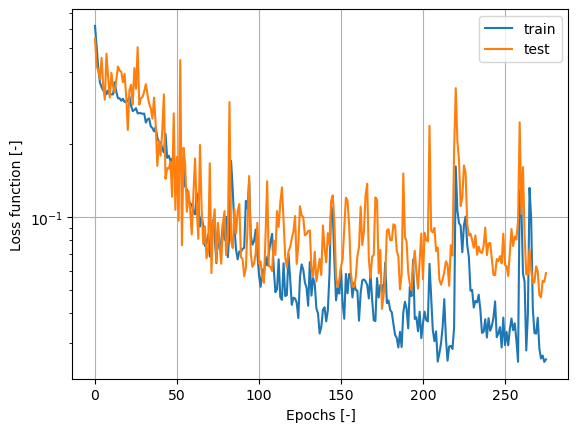

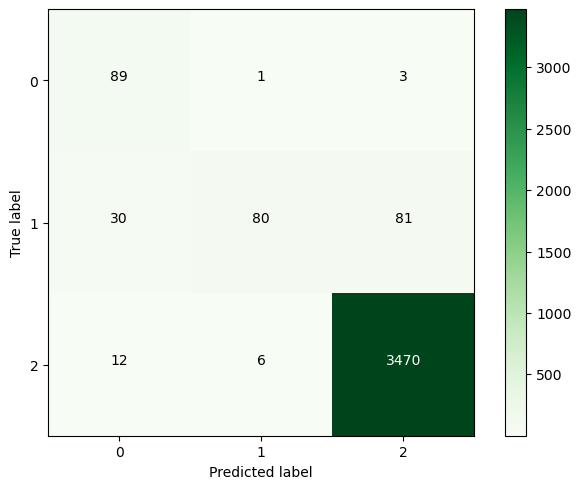

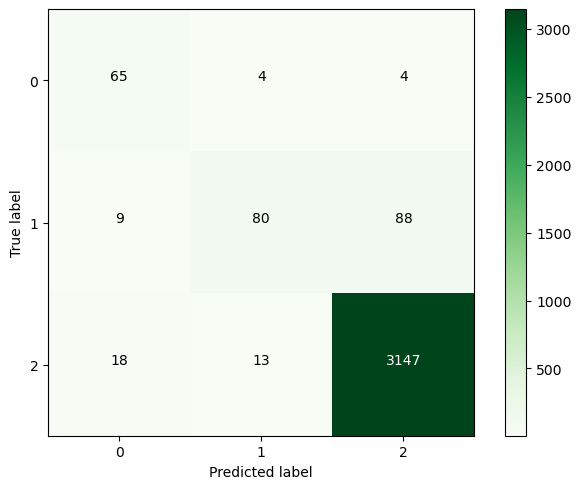

In [54]:
Data = {
    'epochs' : 5000, 
    'batch_size': 200,
    'lr' : 0.001,
    'patience': 100,
    'layers': [256,256,256],
    'activ': "tanh"
    }

HY_Data.append(Data)

Case = "Case_Hyp_Patience_1"

#Training
model_weights ,history_weights = fit_model(X_train, y_train, X_validation, y_validation, Case, class_weights = d_class_weights, **Data)

# Results for the training set
HY_metrics_train.append(final_performance(model_weights, inputTrain, outputTrain, Case + '_train'))

# Results for the test set
HY_metrics_test.append(final_performance(model_weights, inputTest, outputTest, Case + '_test'))

118/118 [==============================] - 0s 979us/step

 Classification report for Case_Hyp_Patience_2_train

              precision    recall  f1-score   support

     Class 1       0.70      0.91      0.79        93
     Class 2       0.91      0.41      0.57       191
     Class 3       0.97      1.00      0.98      3488

    accuracy                           0.96      3772
   macro avg       0.86      0.77      0.78      3772
weighted avg       0.96      0.96      0.96      3772

108/108 [==============================] - 0s 939us/step

 Classification report for Case_Hyp_Patience_2_test

              precision    recall  f1-score   support

     Class 1       0.65      0.82      0.73        73
     Class 2       0.80      0.41      0.54       177
     Class 3       0.97      0.99      0.98      3178

    accuracy                           0.96      3428
   macro avg       0.81      0.74      0.75      3428
weighted avg       0.95      0.96      0.95      3428



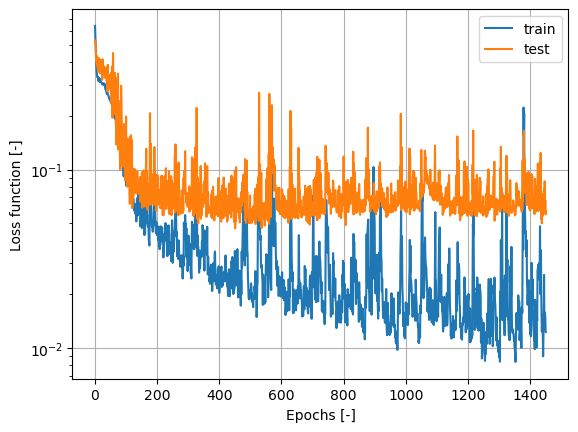

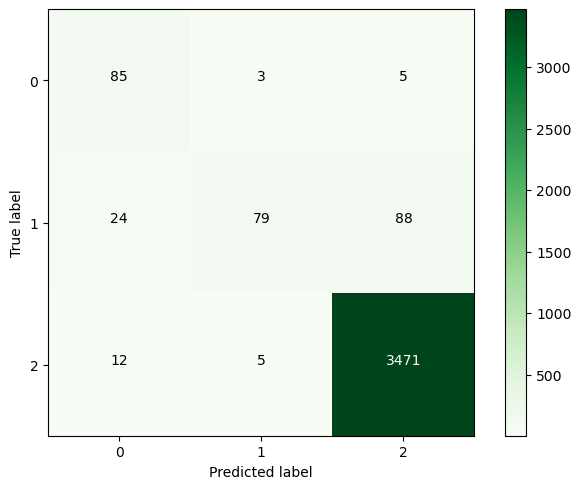

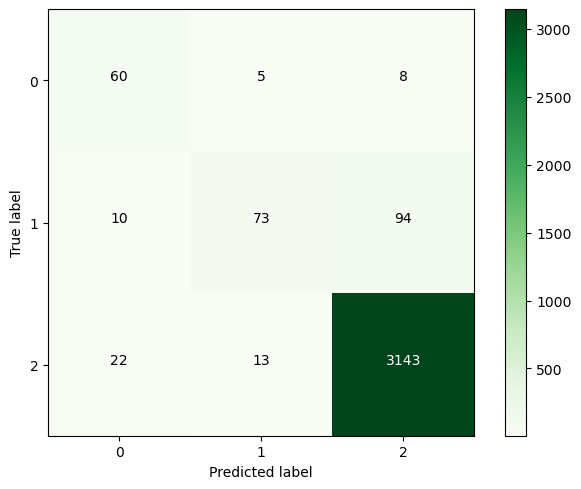

In [55]:
Data = {
    'epochs' : 5000, 
    'batch_size': 500,
    'lr' : 0.001,
    'patience': 1000,
    'layers': [256,256,256],
    'activ': "tanh"
    }

HY_Data.append(Data)

Case = "Case_Hyp_Patience_2"

#Training
model_weights ,history_weights = fit_model(X_train, y_train, X_validation, y_validation, Case, class_weights = d_class_weights, **Data)

# Results for the training set
HY_metrics_train.append(final_performance(model_weights, inputTrain, outputTrain, Case + '_train'))

# Results for the test set
HY_metrics_test.append(final_performance(model_weights, inputTest, outputTest, Case + '_test'))

#### Architecture

118/118 [==============================] - 0s 749us/step

 Classification report for Case_Hyp_Architecture_1_train

              precision    recall  f1-score   support

     Class 1       0.57      0.91      0.71        93
     Class 2       0.71      0.36      0.47       191
     Class 3       0.97      0.99      0.98      3488

    accuracy                           0.95      3772
   macro avg       0.75      0.75      0.72      3772
weighted avg       0.95      0.95      0.95      3772

108/108 [==============================] - 0s 760us/step

 Classification report for Case_Hyp_Architecture_1_test

              precision    recall  f1-score   support

     Class 1       0.51      0.86      0.64        73
     Class 2       0.60      0.38      0.47       177
     Class 3       0.97      0.97      0.97      3178

    accuracy                           0.94      3428
   macro avg       0.69      0.74      0.69      3428
weighted avg       0.94      0.94      0.94      3428



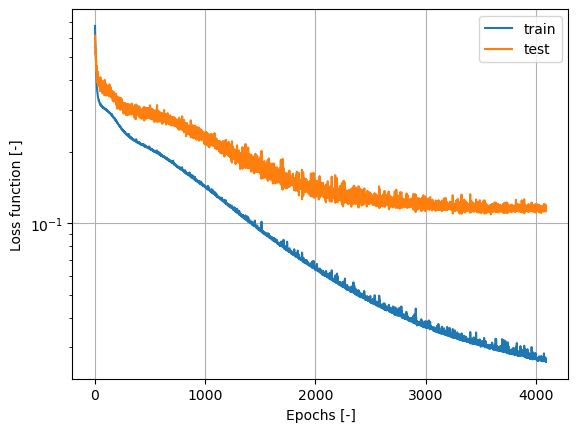

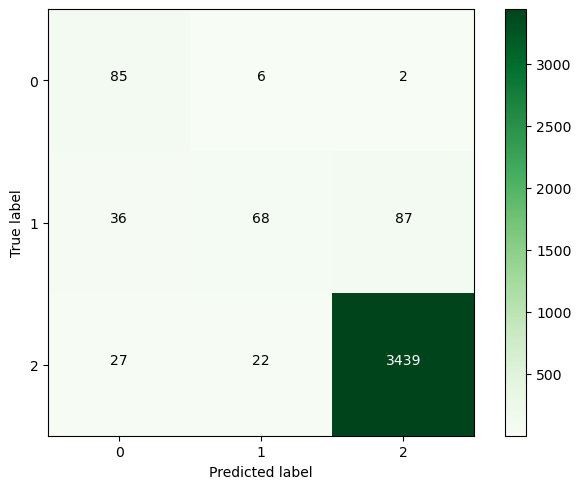

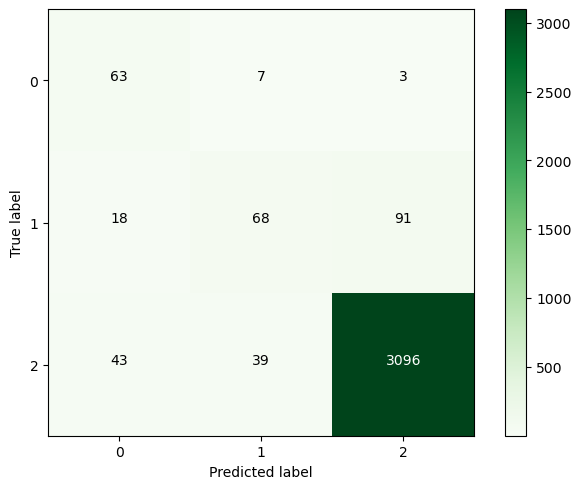

In [56]:
Data = {
    'epochs' : 5000, 
    'batch_size': 200,
    'lr' : 0.001,
    'patience': 500,
    'layers': [256],
    'activ': "tanh"
    }

HY_Data.append(Data)

Case = "Case_Hyp_Architecture_1"

#Training
model_weights ,history_weights = fit_model(X_train, y_train, X_validation, y_validation, Case, class_weights = d_class_weights, **Data)

# Results for the training set
HY_metrics_train.append(final_performance(model_weights, inputTrain, outputTrain, Case + '_train'))

# Results for the test set
HY_metrics_test.append(final_performance(model_weights, inputTest, outputTest, Case + '_test'))

118/118 [==============================] - 0s 1ms/step

 Classification report for Case_Hyp_Architecture_2_train

              precision    recall  f1-score   support

     Class 1       0.56      0.96      0.71        93
     Class 2       0.66      0.41      0.51       191
     Class 3       0.98      0.98      0.98      3488

    accuracy                           0.95      3772
   macro avg       0.73      0.78      0.73      3772
weighted avg       0.95      0.95      0.95      3772

108/108 [==============================] - 0s 990us/step

 Classification report for Case_Hyp_Architecture_2_test

              precision    recall  f1-score   support

     Class 1       0.55      0.89      0.68        73
     Class 2       0.54      0.45      0.49       177
     Class 3       0.97      0.97      0.97      3178

    accuracy                           0.94      3428
   macro avg       0.69      0.77      0.71      3428
weighted avg       0.94      0.94      0.94      3428



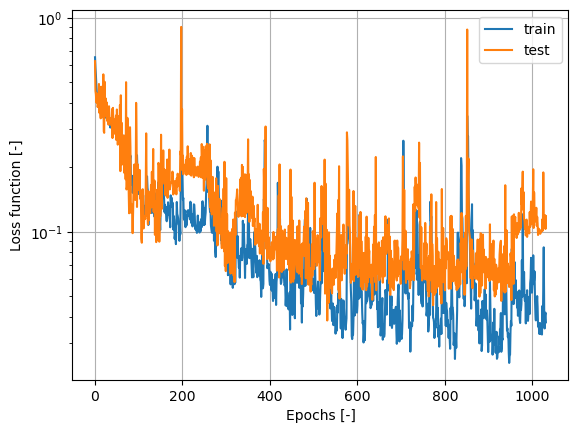

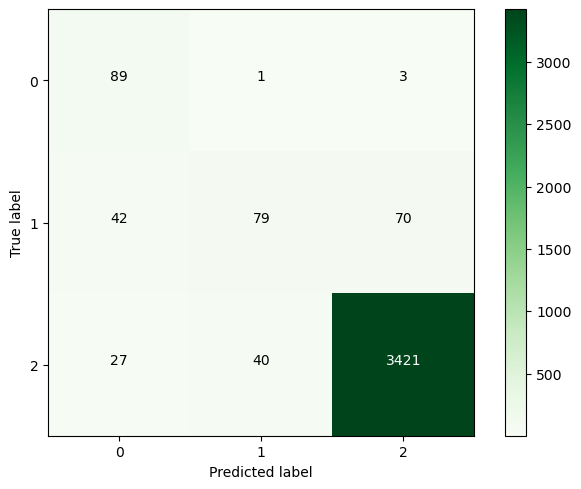

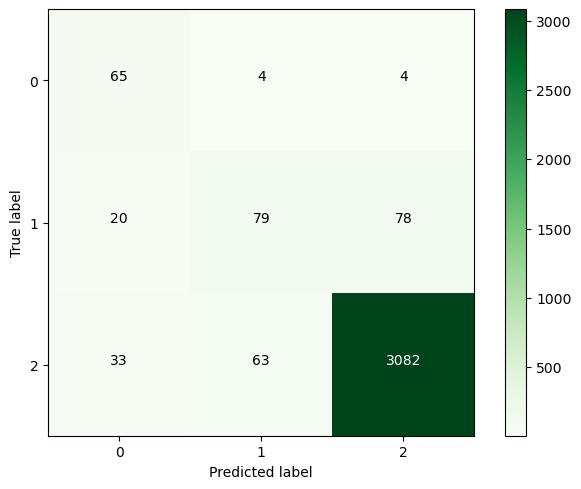

In [57]:
Data = {
    'epochs' : 5000, 
    'batch_size': 500,
    'lr' : 0.001,
    'patience': 500,
    'layers': [256,256,256,64,16],
    'activ': "tanh"
    }

HY_Data.append(Data)

Case = "Case_Hyp_Architecture_2"

#Training
model_weights ,history_weights = fit_model(X_train, y_train, X_validation, y_validation, Case, class_weights = d_class_weights, **Data)

# Results for the training set
HY_metrics_train.append(final_performance(model_weights, inputTrain, outputTrain, Case + '_train'))

# Results for the test set
HY_metrics_test.append(final_performance(model_weights, inputTest, outputTest, Case + '_test'))

#### Activation function

118/118 [==============================] - 0s 2ms/step

 Classification report for Case_Hyp_Activation_1_train

              precision    recall  f1-score   support

     Class 1       0.54      0.99      0.70        93
     Class 2       0.94      0.33      0.49       191
     Class 3       0.98      0.99      0.98      3488

    accuracy                           0.96      3772
   macro avg       0.82      0.77      0.72      3772
weighted avg       0.96      0.96      0.95      3772

108/108 [==============================] - 0s 1ms/step

 Classification report for Case_Hyp_Activation_1_test

              precision    recall  f1-score   support

     Class 1       0.50      0.93      0.65        73
     Class 2       0.80      0.36      0.50       177
     Class 3       0.97      0.98      0.98      3178

    accuracy                           0.95      3428
   macro avg       0.76      0.76      0.71      3428
weighted avg       0.95      0.95      0.94      3428



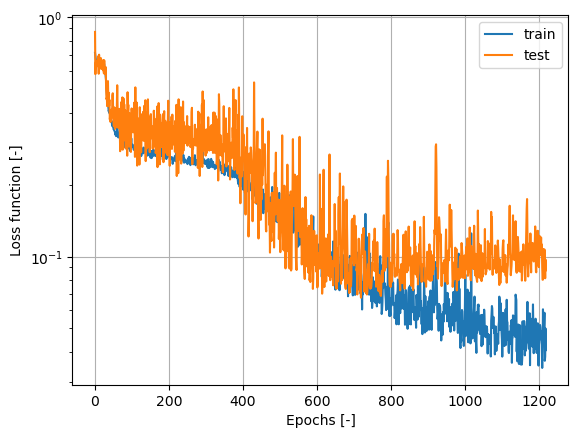

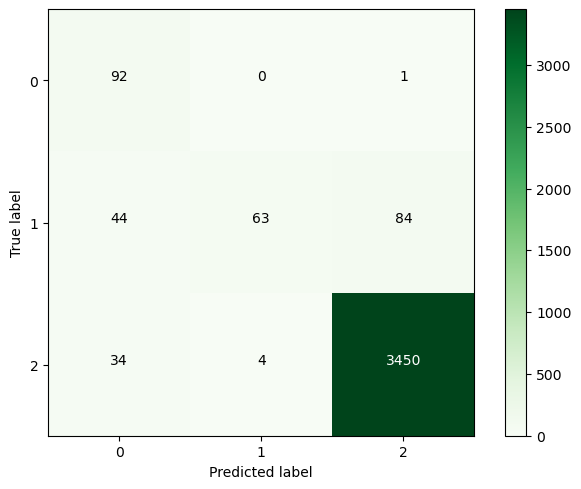

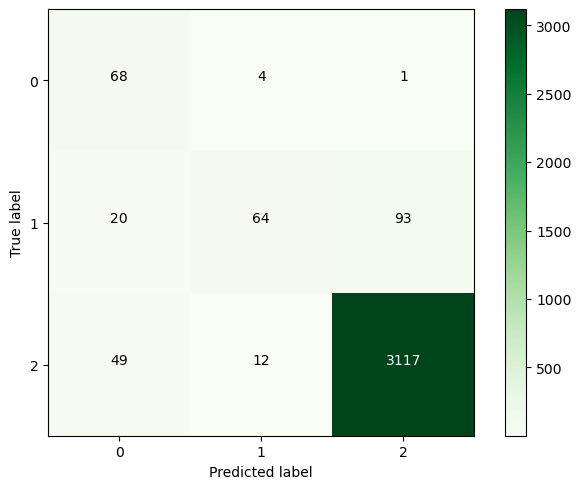

In [58]:
Data = {
    'epochs' : 5000, 
    'batch_size': 200,
    'lr' : 0.001,
    'patience': 500,
    'layers': [256, 256, 256],
    'activ': "sigmoid"
    }

HY_Data.append(Data)

Case = "Case_Hyp_Activation_1"

#Training
model_weights ,history_weights = fit_model(X_train, y_train, X_validation, y_validation, Case, class_weights = d_class_weights, **Data)

# Results for the training set
HY_metrics_train.append(final_performance(model_weights, inputTrain, outputTrain, Case + '_train'))

# Results for the test set
HY_metrics_test.append(final_performance(model_weights, inputTest, outputTest, Case + '_test'))

118/118 [==============================] - 0s 1ms/step

 Classification report for Case_Hyp_Activation_2_train

              precision    recall  f1-score   support

     Class 1       0.64      0.89      0.75        93
     Class 2       0.35      0.76      0.48       191
     Class 3       0.99      0.92      0.95      3488

    accuracy                           0.91      3772
   macro avg       0.66      0.86      0.73      3772
weighted avg       0.95      0.91      0.92      3772

108/108 [==============================] - 0s 1ms/step

 Classification report for Case_Hyp_Activation_2_test

              precision    recall  f1-score   support

     Class 1       0.46      0.68      0.55        73
     Class 2       0.31      0.80      0.44       177
     Class 3       0.99      0.89      0.94      3178

    accuracy                           0.88      3428
   macro avg       0.58      0.79      0.64      3428
weighted avg       0.94      0.88      0.90      3428



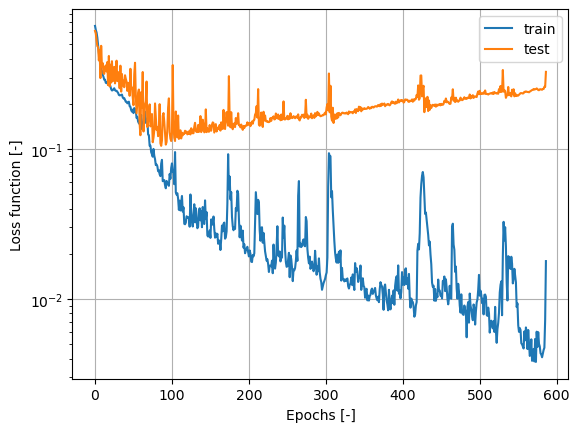

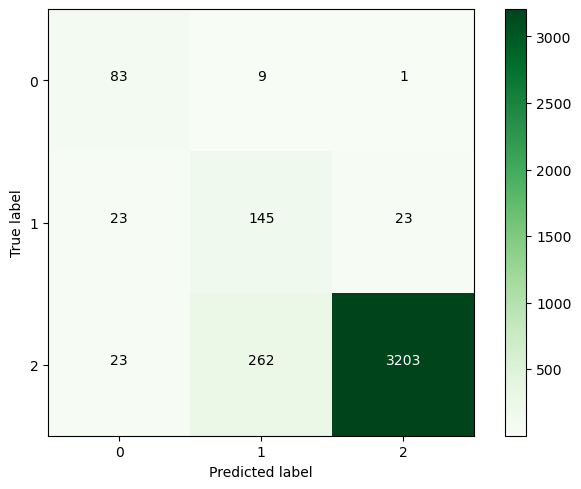

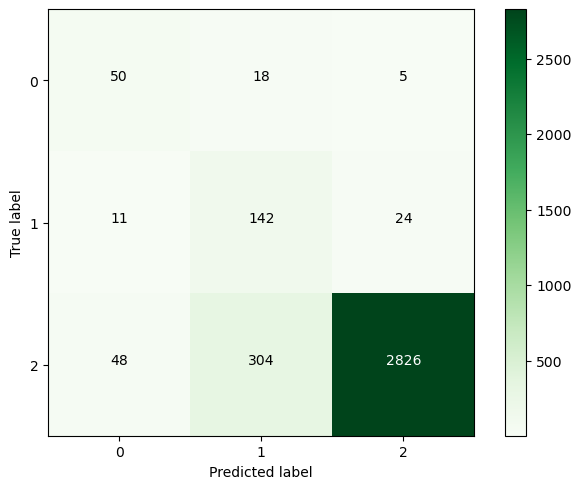

In [59]:
Data = {
    'epochs' : 5000, 
    'batch_size': 500,
    'lr' : 0.001,
    'patience': 500,
    'layers': [256,256,256],
    'activ': "ReLU"
    }

HY_Data.append(Data)

Case = "Case_Hyp_Activation_2"

#Training
model_weights ,history_weights = fit_model(X_train, y_train, X_validation, y_validation, Case, class_weights = d_class_weights, **Data)

# Results for the training set
HY_metrics_train.append(final_performance(model_weights, inputTrain, outputTrain, Case + '_train'))

# Results for the test set
HY_metrics_test.append(final_performance(model_weights, inputTest, outputTest, Case + '_test'))

### Summarizing the results

In [60]:
## Hyperparameter Optimization Data
pd.DataFrame(HY_Data, columns = Data.keys()).to_excel("Metrics/Hyperparameter_Inputs.xlsx")
pd.DataFrame(HY_Data, columns = Data.keys())

,epochs,batch_size,lr,patience,layers,activ
0,5000,200,0.0010,500,"[256, 256, 256]",tanh
1,5000,200,0.0100,500,"[256, 256, 256]",tanh
2,5000,200,0.0001,500,"[256, 256, 256]",tanh
3,5000,100,0.0010,500,"[256, 256, 256]",tanh
4,5000,500,0.0010,500,"[256, 256, 256]",tanh
5,5000,200,0.0010,100,"[256, 256, 256]",tanh
6,5000,500,0.0010,1000,"[256, 256, 256]",tanh
7,5000,200,0.0010,500,[256],tanh
8,5000,500,0.0010,500,"[256, 256, 256, 64, 16]",tanh
9,5000,200,0.0010,500,"[256, 256, 256]",sigmoid


In [61]:
## Hyperparameter Optimization Metrics for the training set
pd.DataFrame(HY_metrics_train, columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']).to_excel("Metrics/Hyperparameter_train.xlsx")
pd.DataFrame(HY_metrics_train, columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])

,Accuracy,Precision,Recall,F1 Score
0,0.965536,0.858100,0.792162,0.782925
1,0.957582,0.797651,0.825966,0.762771
2,0.965005,0.870120,0.787022,0.786720
3,0.965005,0.861178,0.781315,0.786560
4,0.963415,0.842558,0.779661,0.762645
5,0.964740,0.858431,0.790226,0.785233
6,0.963680,0.861477,0.774239,0.782380
7,0.952280,0.752477,0.751984,0.719864
8,0.951485,0.733577,0.783798,0.732383
9,0.955726,0.819143,0.769399,0.723493


In [62]:
## Hyperparameter Optimization Metrics for the test set
pd.DataFrame(HY_metrics_test, columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score']).to_excel("Metrics/Hyperparameter_test.xlsx")
pd.DataFrame(HY_metrics_test, columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])

,Accuracy,Precision,Recall,F1 Score
0,0.963244,0.837601,0.793725,0.795065
1,0.947491,0.736530,0.820976,0.737052
2,0.960910,0.837723,0.780437,0.785789
3,0.959452,0.823930,0.758511,0.768506
4,0.957993,0.813973,0.763352,0.761416
5,0.960327,0.834287,0.777545,0.784218
6,0.955659,0.807646,0.741111,0.750240
7,0.941365,0.691696,0.740464,0.693103
8,0.941074,0.688676,0.768844,0.713909
9,0.947783,0.755692,0.757965,0.707138
